# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from warnings import filterwarnings
filterwarnings('ignore')
# for the progress bar in for loop
from tqdm import tqdm

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

# Read the data

In [2]:
df = pd.read_excel('Election_Data.xlsx', sheet_name='Election_Dataset_Two Classes',
                  usecols=['vote', 'age', 'economic.cond.national','economic.cond.household', 'Blair', 'Hague', 'Europe',
                           'political.knowledge', 'gender'])
print('Shape: {}'.format(df.shape))
df.head()

Shape: (1525, 9)


,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender
0,Labour,43,3,3,4,1,2,2,female
1,Labour,36,4,4,4,4,5,2,male
2,Labour,35,4,4,5,2,3,2,male
3,Labour,24,4,2,2,1,4,0,female
4,Labour,41,2,2,1,1,6,2,male


It is an election vote party choice classification problem using the below features  
 * age
 * gender
 * assessment of current national economic conditions & current household economic conditions on a scale of 1 to 5
 * assessment of the labor leader and the conservative leader on a scale of 1 to 5 
 * measure of respondents attitude towards european integration (high scores represents 'eurosceptic' sentiment)
 * knowledge of parties position on european integration on a scale of 0 to 3.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1525 entries, 0 to 1524
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   vote                     1525 non-null   object
 1   age                      1525 non-null   int64 
 2   economic.cond.national   1525 non-null   int64 
 3   economic.cond.household  1525 non-null   int64 
 4   Blair                    1525 non-null   int64 
 5   Hague                    1525 non-null   int64 
 6   Europe                   1525 non-null   int64 
 7   political.knowledge      1525 non-null   int64 
 8   gender                   1525 non-null   object
dtypes: int64(7), object(2)
memory usage: 107.4+ KB


The target variable is a categorical variable. There is 1 integer variable age and 6 ordinal categorical variables and 1 nominal categorical variable.

## Data Type Conversion 

Let's convert the data type of ordinal categorical columns from integer to Categorical.

In [4]:
ordinal_cols = ['economic.cond.national', 'economic.cond.household', 'Blair', 'Hague', 'Europe', 
                'political.knowledge']

for col in ordinal_cols:
    df[col] = pd.Categorical(df[col], ordered=True)
df.dtypes

vote                         object
age                           int64
economic.cond.national     category
economic.cond.household    category
Blair                      category
Hague                      category
Europe                     category
political.knowledge        category
gender                       object
dtype: object

## Descriptive Statistics

In [5]:
df.describe().round()

,age
count,1525.0
mean,54.0
std,16.0
min,24.0
25%,41.0
50%,53.0
75%,67.0
max,93.0


In [6]:
# displays the unique values for each categorical variable
df_cat = df.select_dtypes(exclude='number')

for col in df_cat.columns:
    uv = np.sort(df[col].unique())
    print('\n'+col + '\nUnique values: {}'.format(uv))
    print('Percentage of Values in each bin:')
    print(np.round(df[col].value_counts(normalize=True)*100))


vote
Unique values: ['Conservative' 'Labour']
Percentage of Values in each bin:
Labour          70.0
Conservative    30.0
Name: vote, dtype: float64

economic.cond.national
Unique values: [1 2 3 4 5]
Percentage of Values in each bin:
3    40.0
4    36.0
2    17.0
5     5.0
1     2.0
Name: economic.cond.national, dtype: float64

economic.cond.household
Unique values: [1 2 3 4 5]
Percentage of Values in each bin:
3    42.0
4    29.0
2    18.0
5     6.0
1     4.0
Name: economic.cond.household, dtype: float64

Blair
Unique values: [1 2 3 4 5]
Percentage of Values in each bin:
4    55.0
2    29.0
5    10.0
1     6.0
3     0.0
Name: Blair, dtype: float64

Hague
Unique values: [1 2 3 4 5]
Percentage of Values in each bin:
2    41.0
4    37.0
1    15.0
5     5.0
3     2.0
Name: Hague, dtype: float64

Europe
Unique values: [ 1  2  3  4  5  6  7  8  9 10 11]
Percentage of Values in each bin:
11    22.0
6     14.0
3      8.0
4      8.0
5      8.0
8      7.0
9      7.0
1      7.0
10     7.0
7    

*Summary on data types of the independent features*
* We have 1 continuous numerical feature - age
* We have 1 nominal categorical feature - gender
* We have 6 ordinal categorical features - economic.cond.national, economic.cond.household, Blair, Hague, Europe, political.knowledge

*Summary on Descriptive Statistics of the Data*
* The assessment of current national economic condition is either 3 or 4 for 75% of the data.
* The assessment of current national household condition is either 3 or 4 for 70% of the data.
* The assessment of labour leader is either 2 or 4 for around 80% of the data.
* The assessment of conservative leader is either 2 or 4 for around 75% of the data.
* Around 22% of the data is very eurosceptic with a measure of 11 on a 1 to 11 scale.
* The knowledge of the parties positions for around 50% of the data is 2 and is 0 for around 30% of the data. 
* We have almost balanced records for both male and female.
* Age ranges from 24 to 93 with a mean of 54 and a standard deviation of 16. The mean and median are close, hence the distribution may not be skewed.

## Missing Values

In [7]:
df.isna().sum()

vote                       0
age                        0
economic.cond.national     0
economic.cond.household    0
Blair                      0
Hague                      0
Europe                     0
political.knowledge        0
gender                     0
dtype: int64

There are no missing values in the dataset

## Skewness

In [8]:
df['age'].skew()

0.14462077228942483

The skewness of age is within the range of -0.5 to 0.5. Hence the distribution of age is not skewed.

# Univariate Analysis

## Countplot

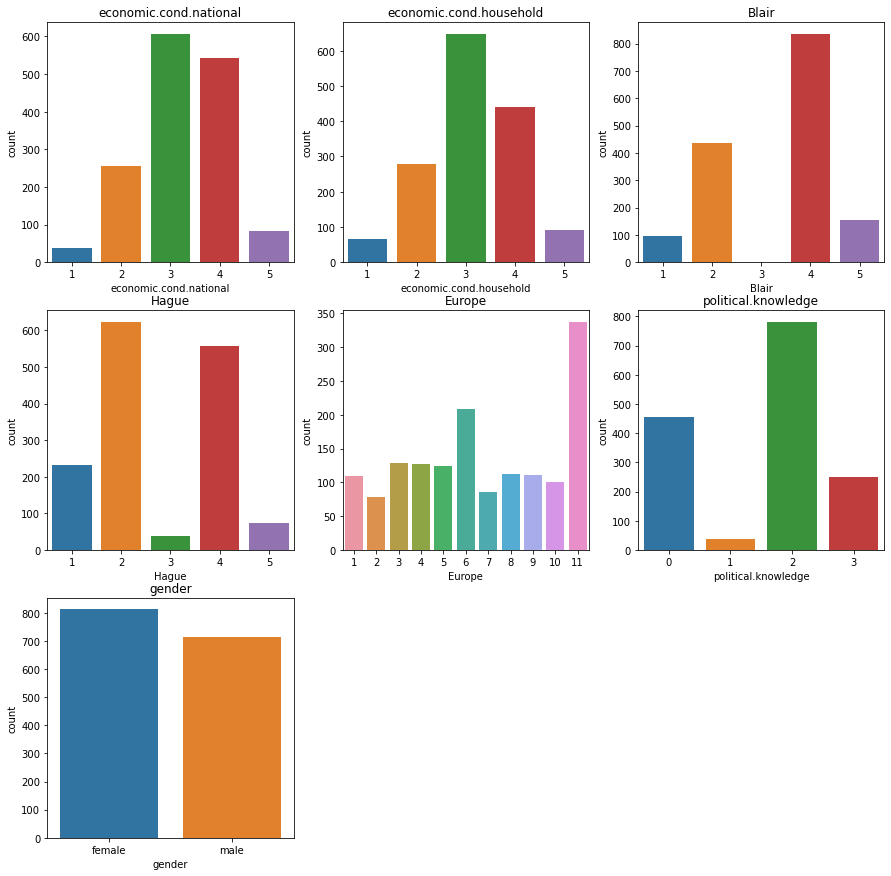

In [9]:
plt.figure(figsize=(15,15))
catcol_lst = list(df_cat.columns)
catcol_lst.remove('vote')

for i,col in enumerate(catcol_lst):
    ax = plt.subplot(3, 3, i+1)
    sns.countplot(data=df_cat, x=col, ax=ax)
    ax.title.set_text(col)
    
plt.show()

We notice outliers in the ordinal categorical features 
  * economic.cond.national (1 & 5)
  * economic.cond.household (1 & 5)
  * Blair (1,3 & 5)
  * Hague (3 & 5)
  * political knowledge (1).

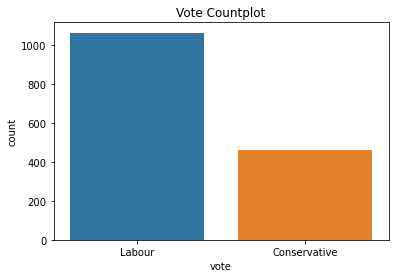

In [10]:
sns.countplot(data=df_cat, x='vote')
plt.title('Vote Countplot')
plt.show()

*Is the data balanced or imbalanced ?*

We notice 70% is labour and 30% is Conservative. 70% - 30% ratio can be considered as a balanced dataset. Hence the dataset is balanced. Hence we use ROC AUC as the performance metric to evaluate the model performance.

## Distribution plot & Boxplot

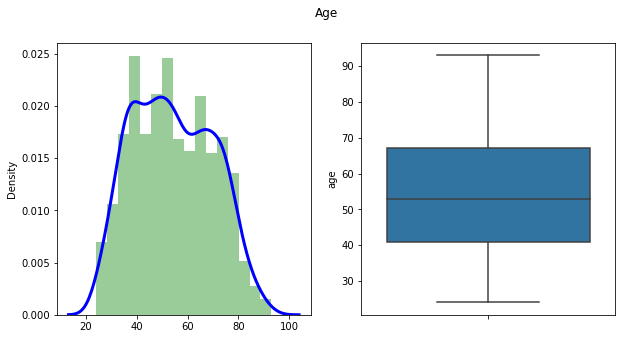

In [11]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
sns.distplot(x=df['age'], kde_kws={"color": "b", "lw": 3, "label": "KDE"}, hist_kws={"color": "g"})
plt.subplot(1, 2, 2)
sns.boxplot(y=df['age'])
plt.suptitle('Age')
plt.show()

The age distribution is approximately symmetrical and there are no outliers.

## Bivariate Analysis

### Age Vs Vote

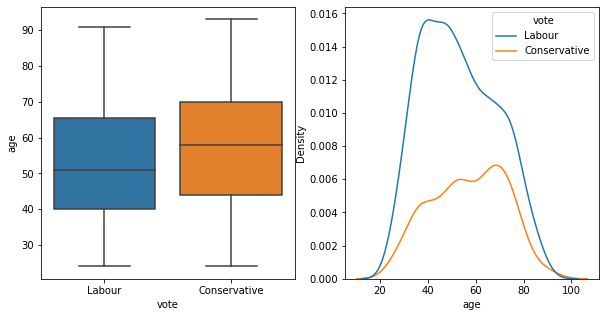

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(x='vote', y='age', data=df)
plt.subplot(1,2,2)
sns.kdeplot(data=df, x="age", hue="vote")
plt.show()
plt.show()

The spread of Conservative is just slightly in a higher range than Labour. Hence we can say the contribution of age for building the model be minimal.

### Hague vs vote

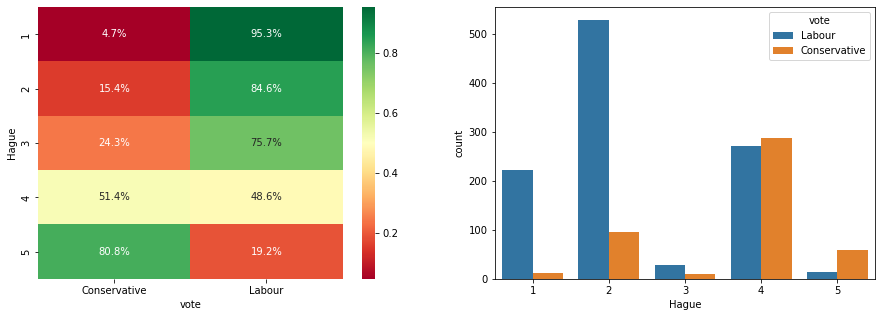

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.heatmap(pd.crosstab(index=df['Hague'], columns=df['vote'], normalize='index'), annot=True, fmt=".1%", 
            cmap='RdYlGn')
plt.subplot(1, 2, 2)
sns.countplot(x='Hague', hue='vote', data=df)
plt.show()

Except 4, all others count values differ heavily for Labour and Conservative. Hence we could say Hague is a good feature for building a model to classify the target variable.

### Europe Vs Vote

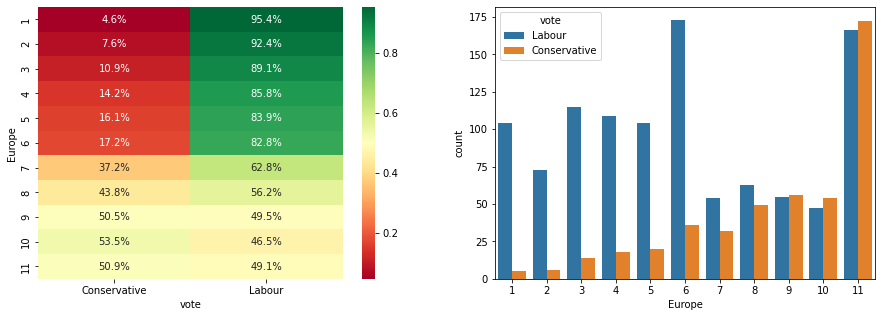

In [14]:
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.heatmap(pd.crosstab(index=df['Europe'], columns=df['vote'], normalize='index'), annot=True, fmt=".1%", 
            cmap='RdYlGn')
plt.subplot(1, 2, 2)
sns.countplot(x='Europe', hue='vote', data=df)
plt.show()

There are heavy differences in the bar length for Labour and Conservative from 1 to 8. Hence we could say Europe is a good feature for building the model.

## Handling Outliers 

### Numeric data

In [15]:
print('Z Score Outliers percent')
col = 'age'
mu = df[col].mean() 
sd = df[col].std() 
ub = mu + 3 * sd 
lb = mu - 3 * sd
zscore_outliers = df[(df[col]<lb)|(df[col]>ub)].copy() 
outliers_pct = len(zscore_outliers)/len(df)
print('{} - {:.2%}'.format(col, outliers_pct)) 

Z Score Outliers percent
age - 0.00%


### Categorical Data

In [16]:
for col in df_cat.columns:
    print('\n' + col + ' - Value Counts Percentage')
    print(df_cat[col].value_counts(normalize=True).round(4)*100)


vote - Value Counts Percentage
Labour          69.7
Conservative    30.3
Name: vote, dtype: float64

economic.cond.national - Value Counts Percentage
3    39.80
4    35.54
2    16.85
5     5.38
1     2.43
Name: economic.cond.national, dtype: float64

economic.cond.household - Value Counts Percentage
3    42.49
4    28.85
2    18.36
5     6.03
1     4.26
Name: economic.cond.household, dtype: float64

Blair - Value Counts Percentage
4    54.82
2    28.72
5    10.03
1     6.36
3     0.07
Name: Blair, dtype: float64

Hague - Value Counts Percentage
2    40.92
4    36.59
1    15.28
5     4.79
3     2.43
Name: Hague, dtype: float64

Europe - Value Counts Percentage
11    22.16
6     13.70
3      8.46
4      8.33
5      8.13
8      7.34
9      7.28
1      7.15
10     6.62
7      5.64
2      5.18
Name: Europe, dtype: float64

political.knowledge - Value Counts Percentage
2    51.28
0    29.84
3    16.39
1     2.49
Name: political.knowledge, dtype: float64

gender - Value Counts Percentage
fem

**Ordinal Categorical Data**

economic.cond.national, economic.cond.household

* 1 & 5 are outliers as they have very low percentage. We can replace 1 with 2 and 5 with 4.

Blair

* 1 & 3 are outliers. We can replace 1 with 2 and 3 with 4.

Hague

* 3 & 5 are outliers. We can replace 5 with 4 and 3 with 2.

Europe

* There are no outliers

political.knowledge

* 1 is a outlier. We can replace 1 with 2.

**Nominal Categorical Data**

Vote and gender has only 2 categories. Hence no need to check for outliers.

#### Outliers Proportion

In [17]:
out_cols = ['economic.cond.national', 'economic.cond.household', 'Blair', 'Hague', 'political.knowledge']
replace_dt = [{1:2, 5:4}, {1:2, 5:4}, {1:2, 3:4}, {3:2, 5:4}, {1:2}]
ndf = df.copy()

# code to treat the outliers
# out_df = df.copy()
# for col,dt in zip(out_cols, replace_dt):
#     out_df[col] = out_df[col].replace(dt)

print('Outliers Percentage')
for col,dt in zip(out_cols, replace_dt):
    # dt.keys() gives the outlier values
    print('{} - {:.2%}'.format(col, len(ndf[ndf[col].isin(dt.keys())])/len(df)))
    # store all the non-outlier values in ndf
    ndf = ndf[~ndf[col].isin(dt.keys())]
np.round((len(df)-len(ndf))/len(df)*100,1)

Outliers Percentage
economic.cond.national - 7.80%
economic.cond.household - 7.74%
Blair - 4.92%
Hague - 5.11%
political.knowledge - 1.77%


27.3

We have 27.3% of outliers in the data. It is not neccessary to treat them as Decision Tree and Random Forest are
not sensitive to outliers.

## Encoding

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
nominal_cols = ['vote', 'gender']

# we encode Labour as 1 and Conservative as 0; male as 1 and female as 0
for col in nominal_cols:
    df[col] = le.fit_transform(df[col])
    df[col] = pd.Categorical(df[col])
    
df.head()

,vote,age,economic.cond.national,economic.cond.household,Blair,Hague,Europe,political.knowledge,gender
0,1,43,3,3,4,1,2,2,0
1,1,36,4,4,4,4,5,2,1
2,1,35,4,4,5,2,3,2,1
3,1,24,4,2,2,1,4,0,0
4,1,41,2,2,1,1,6,2,1


Scaling is not necessary for decision trees and ensemble algorithms as they are not sensitive to the variance in the data. Hence the check of difference in scale of different features on the basis of appropriate measure for example std dev, variance is not necessary.

# Train Test Split

In [19]:
y = df['vote']
X = df.iloc[:, 1:]

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=0)
for d in [xtrain, xtest, ytrain, ytest]:
    print('{:.1%}'.format(d.shape[0]/len(df)))

70.0%
30.0%
70.0%
30.0%


We are choosing 70-30% percentage as train-test split ratio. The train-test split is performed to estimate the performance of the ML model.

# Decision Tree Classifier

## Fully Grown Decision Tree

In [20]:
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(xtrain, ytrain)

ypred = dtc.predict(xtest)
ypred_train = dtc.predict(xtrain)

fgdt_train_score = roc_auc_score(ytrain, ypred_train)
fgdt_test_score = roc_auc_score(ytest, ypred)

DT = DecisionTreeClassifier(random_state=0)
kf = KFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(DT, X, y, cv=kf, scoring='roc_auc')

print('Training ROC AUC Score: {:.0%}'.format(fgdt_train_score))
print('Test ROC AUC Score: {:.0%}'.format(fgdt_test_score))

print('Scores: {}'.format([np.round(x*100, 2) for x in scores]))
fgdt_avg_rascore = np.mean(scores)
fgdt_ve = np.std(scores)/np.mean(scores)
print('Average ROC AUC Score: {:.2%}\nVariance Error: {:.2%}'.format(fgdt_avg_rascore, fgdt_ve))

Training ROC AUC Score: 100%
Test ROC AUC Score: 76%
Scores: [73.46, 71.93, 69.26, 71.59, 72.34]
Average ROC AUC Score: 71.72%
Variance Error: 1.92%


We are using ROC AUC score as the performance metric as ROC AUC is a good metric for classification of balanced dataset.

The Test accuracy of a Fully Grown Decision tree for the given dataset is only 76% and we notice a huge difference between the Training score and Test score. 

Hence let's find the best values for the max depth and criterion parameters and build a regularized Decision Tree.

## Find the best params

In [21]:
DT = DecisionTreeClassifier(random_state=0)
params = {'max_depth': np.arange(2,10), 'criterion': ['entropy','gini']}
kf = KFold(n_splits=5, shuffle=True, random_state=0)

GS = GridSearchCV(DT, params, cv=kf, scoring='roc_auc')
GS.fit(X, y)
GS.best_params_

{'criterion': 'gini', 'max_depth': 4}

## Regularized Decision Tree

A Regularized Decision tree is built using the best params identified.

In [22]:
dtc = DecisionTreeClassifier(max_depth=4, criterion='gini', random_state=0)
dtc.fit(xtrain, ytrain)

ypred_rdt = dtc.predict(xtest)
ypred_train_rdt = dtc.predict(xtrain)
ypred_prob_rdt = dtc.predict_proba(xtest)[:,1]

test_rocscore_rdt = roc_auc_score(ytest, ypred_rdt)
train_rocscore_rdt = roc_auc_score(ytrain, ypred_train_rdt)

print("Training ROC AUC score: {:.0%}".format(train_rocscore_rdt))
print("Test ROC AUC score: {:.0%}".format(test_rocscore_rdt))

Training ROC AUC score: 81%
Test ROC AUC score: 81%


The regularization has increased the test accuracy by around 5% from 76% to 81%.

## Cross Validation

In [23]:
# Validate model performance using K-fold Cross Validation using roc scoring

DT = DecisionTreeClassifier(max_depth=4, criterion='gini', random_state=0)
kf = KFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(DT, X, y, cv=kf, scoring='roc_auc')

print('Scores: {}'.format([np.round(x*100, 2) for x in scores]))
avg_rascore_rdt = np.mean(scores)
rdt_ve = np.std(scores)/np.mean(scores)
print('Average ROC AUC Score: {:.2%}\nVariance Error: {:.2%}'.format(avg_rascore_rdt, rdt_ve))

Scores: [84.23, 90.49, 82.86, 85.31, 88.52]
Average ROC AUC Score: 86.28%
Variance Error: 3.26%


The Average ROC AUC Score is 86.28% which is a good score and the variance error is 3.26% which is less than 5% , hence the variance error is also minimal. Hence we can say the regularized decision tree model is neither overfitting nor underfitting.

In [24]:
round(pd.Series(ypred).map({0:'Conservative', 1:'Labour'}).value_counts(normalize=True)*100)

Labour          69.0
Conservative    31.0
dtype: float64

As per our regularized Decision Tree model, the overall win is predicted as Labour.

## ROC Curve

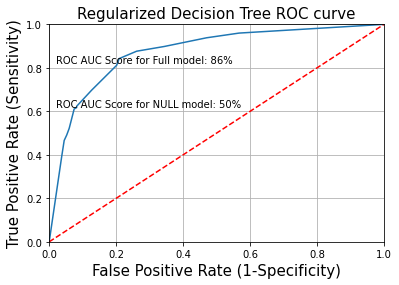

In [25]:
def plot_roc_curve(ytest, ypred_prob, avg_rascore, title):
    fpr, tpr, thresholds = roc_curve(ytest, ypred_prob)

    # plot the ROC curve
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], 'r--')

    plt.title(title+' ROC curve', fontsize = 15)
    plt.xlabel('False Positive Rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)
    
    plt.text(x = 0.02, y = 0.82, s = ('ROC AUC Score for Full model: {:.0%}'.format(avg_rascore)))
    plt.text(x = 0.02, y = 0.62, s = ('ROC AUC Score for NULL model: 50%'))
    plt.grid(True)
    
plot_roc_curve(ytest, ypred_prob_rdt, avg_rascore_rdt, 'Regularized Decision Tree')

A decision tree model with 86% accuracy and 3.26% variance error, has been built to predict the overall win and seats covered by the parties Labour and Conservative. The overall win is predicted as Labour with 70% of votes. And Conservative party has been predicted to secure 30% of votes.

## Feature Importance Score

In [26]:
fis_lst = []
for col,score in zip(X.columns, dtc.feature_importances_*100):
    fis_lst.append((col,round(score)))
fis_lst.sort(key=lambda x: x[1], reverse=True)
dict(fis_lst)

{'Hague': 45,
 'Europe': 20,
 'Blair': 17,
 'political.knowledge': 13,
 'age': 2,
 'economic.cond.household': 2,
 'economic.cond.national': 1,
 'gender': 0}

The feature that contributes the most in building the model is Hague,the assessment of conservative leader. The second most important feature is Europe. The feature importance score of gender is 0. The column gender provides no contribution to building the model.

## Visualize the tree

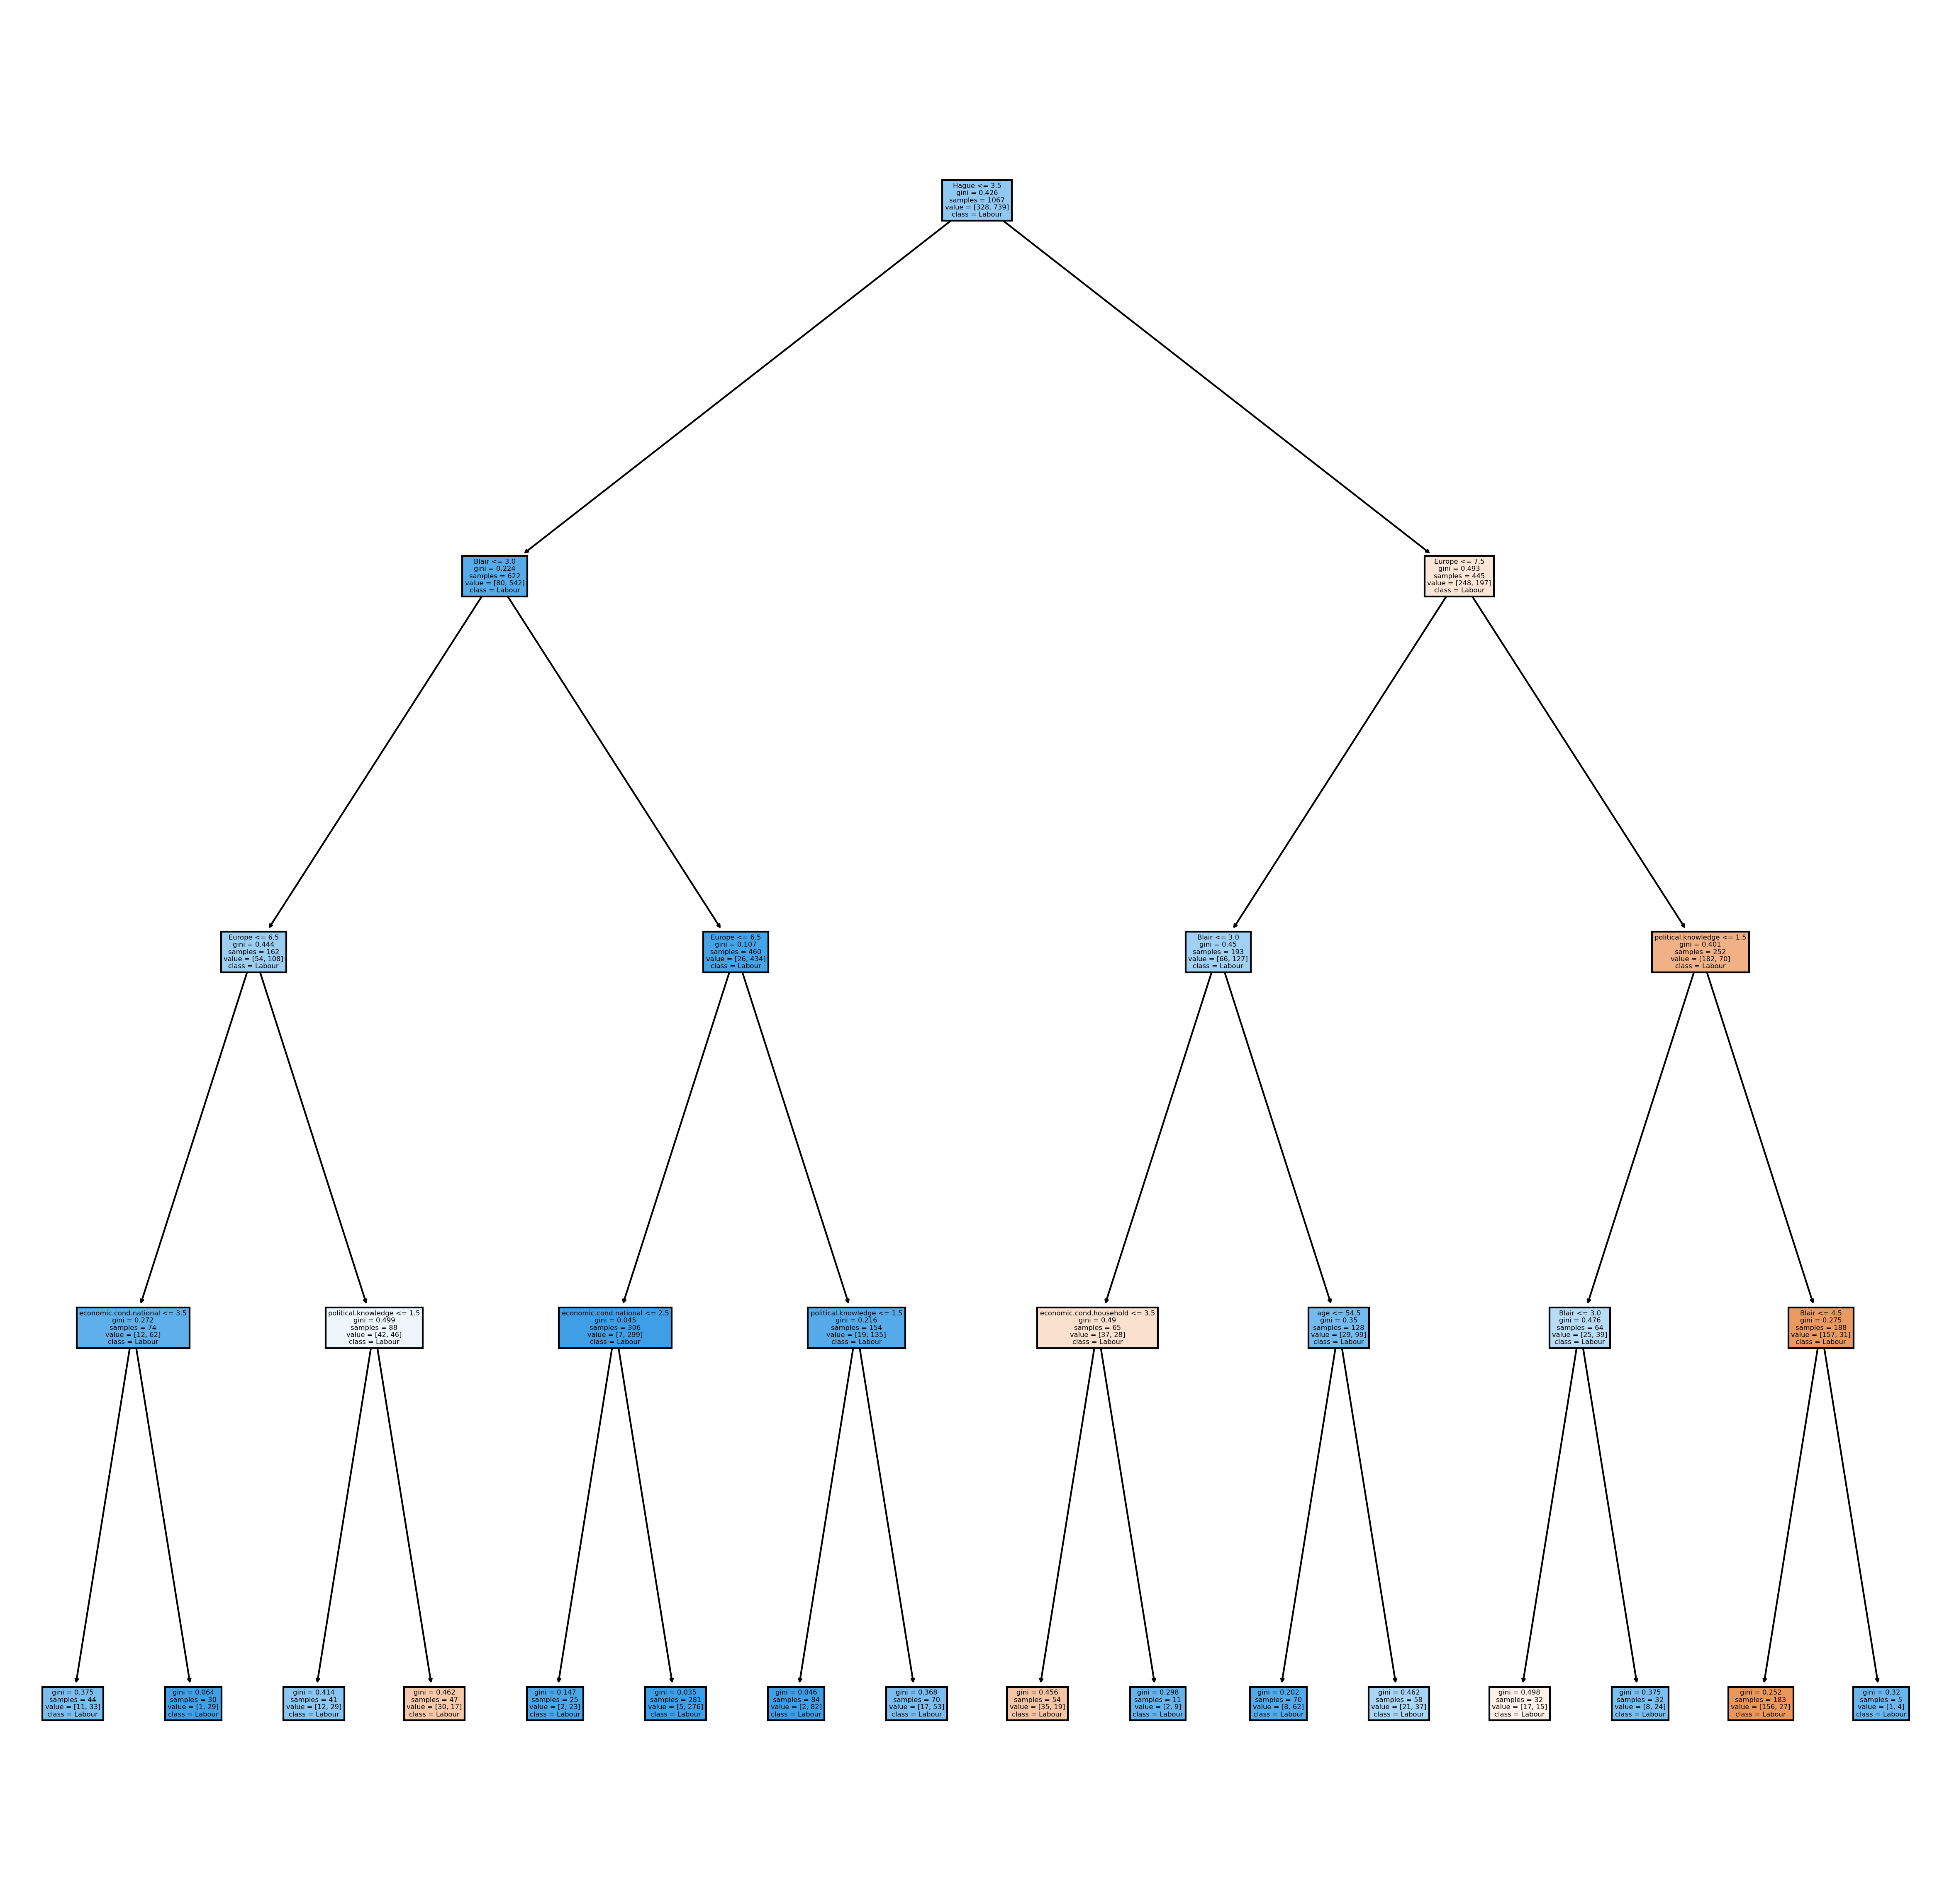

In [27]:
from sklearn import tree

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20,20), dpi=300)
tree.plot_tree(dtc, feature_names = X.columns, 
               class_names=pd.Series(ypred).map({0:'Conservative',1:'Labour'}),
               filled = True);
fig.savefig('tree_img.png')

# Random Forest

## Identify the best criterion and nestimator

We identify the best nestimator by building a random forest model for a range of nestimators 1 to 50 and select the one with minimum variance error.

In [28]:
def find_be_ve(X, y):
    RF_ve_en = []
    RF_be_en = []
    RF_ve_gi = []
    RF_be_gi = []
    
    for criterion in ['gini','entropy']:
        
        for i in tqdm(np.arange(1, 25)):
            RF = RandomForestClassifier(n_estimators=i, criterion=criterion, random_state=42)
            kf = KFold(n_splits=5, shuffle=True, random_state=0)
            scores = cross_val_score(RF, X, y, cv=kf, scoring='roc_auc')
            
            if criterion == 'gini':
                RF_be_gi.append(np.mean(1-scores))
                RF_ve_gi.append(np.std(1-scores, ddof=1))
            else:
                RF_be_en.append(np.mean(1-scores))
                RF_ve_en.append(np.std(1-scores, ddof=1))
                
    return RF_be_en,RF_ve_en,RF_be_gi,RF_ve_gi

In [29]:
RF_be_en,RF_ve_en,RF_be_gi,RF_ve_gi = find_be_ve(X,y)
min_ve_en = round(np.min(RF_ve_en)*100,2)
minveen_nest = np.argmin(RF_ve_en)+1
min_ve_gi = round(np.min(RF_ve_gi)*100,2)
minvegi_nest = np.argmin(RF_ve_gi)+1
    
print('The minimum variance error for entropy is {}'.format(min_ve_en))
print('The respective nestimator for the minimum variance error for entropy is {}'.format(minveen_nest))
print('\nThe minimum variance error for gini is {}'.format(min_ve_gi))
print('The respective nestimator for the minimum variance error for gini is {}'.format(minvegi_nest))

if min_ve_en < min_ve_gi:
    print('\nEntropy Minimum Variance error is lesser. Hence we choose entropy. Hence the choosen nestimator is {}'.format(minveen_nest))
else:
    print('\nGini Minimum Variance error is lesser. Hence we choose gini. Hence the choosen nestimator is {}'.format(minvegi_nest))

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:08<00:00,  2.91it/s]

The minimum variance error for entropy is 1.46
The respective nestimator for the minimum variance error for entropy is 5

The minimum variance error for gini is 0.92
The respective nestimator for the minimum variance error for gini is 4

Gini Minimum Variance error is lesser. Hence we choose gini. Hence the choosen nestimator is 4


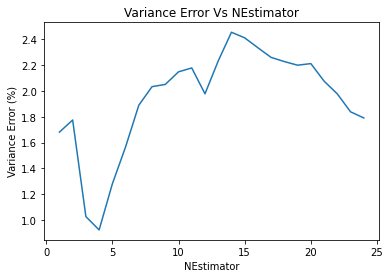

In [30]:
plt.plot(np.arange(1,25), np.array(RF_ve_gi)*100)
plt.xlabel('NEstimator')
plt.ylabel('Variance Error (%)')
plt.title('Variance Error Vs NEstimator')
plt.show()

## Build the model

In [31]:
# building the RF Model
RF_final = RandomForestClassifier(n_estimators=4, criterion='gini', random_state=42)
RF_final.fit(xtrain, ytrain)

ypred_rf = RF_final.predict(xtest)
ypred_train_rf = RF_final.predict(xtrain)
ypred_prob_rf = RF_final.predict_proba(xtest)[:,1]
train_rocscore_rf = roc_auc_score(ytrain, ypred_train_rf)
test_rocscore_rf = roc_auc_score(ytest, ypred_rf)

print("RF ROC AUC Training score: {:.2%}".format(train_rocscore_rf))
print("RF ROC AUC Test score: {:.2%}".format(test_rocscore_rf))

# cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)
scores = cross_val_score(RF_final, X, y, cv=kf, scoring='roc_auc')
rf_avg_rascore = np.mean(scores)
rf_ve = np.std(scores)/np.mean(scores)

print('\nRF Average ROC AUC Score: {:.2%}'.format(rf_avg_rascore))
print('RF Variance Error: {:.2%}'.format(rf_ve))

RF ROC AUC Training score: 97.43%
RF ROC AUC Test score: 76.27%

RF Average ROC AUC Score: 83.25%
RF Variance Error: 0.99%


## ROC Curve

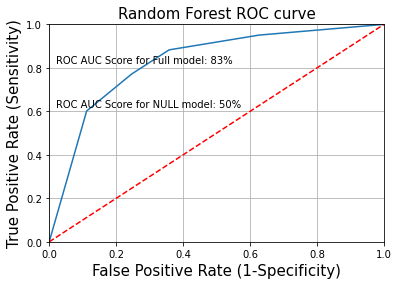

In [32]:
plot_roc_curve(ytest, ypred_prob_rf, rf_avg_rascore, 'Random Forest')

In [33]:
round(pd.Series(ypred_rf).map({0:'Conservative', 1:'Labour'}).value_counts(normalize=True)*100)

Labour          62.0
Conservative    38.0
dtype: float64

The Random Forest Average ROC AUC Score is 83.25% which is lesser than the Regularized Decision Tree Average ROC AUC Score 86.28%. But the RF Variance error 0.99% is much better than Decision Tree Variance Error 3.26%. Hence through Random Forest we have improved the variance error with a little bit sacrifice in the bias error. Hence we have built a much reliable model through random forest though the accuracy has been sacrificed a little bit.

According to RF model, the overall win is predicted as Labour with 62% of votes.

Lets improve the bias error by boosting the Random Forest model using the AdaBoostClassifier.

## Boost RF using Ada Boost Classifier

### Identify the best nestimator

In [34]:
# Tuning the n_estimator for Random Forest with customized GridSearchCV
RFB_ve = []
RFB_be = []

for i in tqdm(np.arange(1,25)):
    RF_boost = AdaBoostClassifier(base_estimator=RF_final, n_estimators=i, random_state=42)
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = cross_val_score(RF_boost, X, y, cv=kf, scoring='roc_auc')
    RFB_be.append(np.mean(1-scores))
    RFB_ve.append(np.std(1-scores, ddof=1))

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:36<00:00,  1.53s/it]


In [35]:
print('The minimum bias error for Ada Boost Classifier is {:.2%}'.format(np.min(RFB_be)))
print('The respective nestimator for the minimum bias error is {}'.format(np.argmin(RFB_be)+1))

The minimum bias error for Ada Boost Classifier is 14.33%
The respective nestimator for the minimum bias error is 3


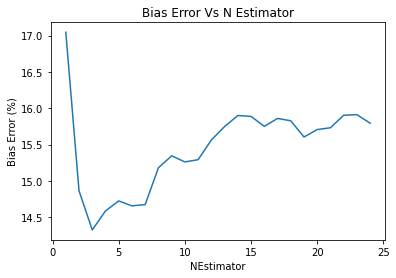

In [36]:
plt.plot(np.arange(1,25), np.array(RFB_be)*100)
plt.xlabel('NEstimator')
plt.ylabel('Bias Error (%)')
plt.title('Bias Error Vs N Estimator')
plt.show()

### Build the model

In [37]:
RF_boost_tuned = AdaBoostClassifier(base_estimator=RF_final, n_estimators=3, random_state=42)
RF_boost_tuned.fit(xtrain, ytrain)

ypred_rfab = RF_boost_tuned.predict(xtest)
ypred_train_rfab = RF_boost_tuned.predict(xtrain)
ypred_prob_rfab = RF_boost_tuned.predict_proba(xtest)[:,1]
train_rocscore_rfab = roc_auc_score(ytrain, ypred_train_rfab)
test_rocscore_rfab = roc_auc_score(ytest, ypred_rfab) 

scores_rfab = cross_val_score(RF_boost_tuned, X, y, cv=kf, scoring='roc_auc')
rfab_avgrascore = np.mean(scores_rfab)
rfab_ve = np.std(scores)/np.mean(scores)

print("RF Ada Boosted ROC AUC Training score: {:.2%}".format(train_rocscore_rfab))
print("RF Ada Boosted ROC AUC Test score: {:.2%}".format(test_rocscore_rfab))
print('\nRF Ada Boosted Average ROC AUC Score: {:.2%}'.format(rfab_avgrascore))
print('RF Ada Boosted Variance Error: {:.2%}'.format(rfab_ve))

RF Ada Boosted ROC AUC Training score: 99.27%
RF Ada Boosted ROC AUC Test score: 76.11%

RF Ada Boosted Average ROC AUC Score: 85.67%
RF Ada Boosted Variance Error: 2.07%


In [38]:
model_names = ['Fully Grown Decision Tree', 'Regularized Decision Tree', 'Random Forest', 'Random Forest Ada Boosted']
scores_df = pd.DataFrame({'Model Name': model_names,
                          'Training Score': [fgdt_train_score, train_rocscore_rdt, train_rocscore_rf, train_rocscore_rfab],
                          'Test Score': [fgdt_test_score, test_rocscore_rdt, test_rocscore_rf, test_rocscore_rfab],
                          'Average Score': [fgdt_avg_rascore, avg_rascore_rdt, rf_avg_rascore, rfab_avgrascore],
                          'Variance Error': [fgdt_ve, rdt_ve, rf_ve, rfab_ve]})
scores_df

,Model Name,Training Score,Test Score,Average Score,Variance Error
0,Fully Grown Decision Tree,1.000000,0.757762,0.717154,0.019232
1,Regularized Decision Tree,0.810031,0.807675,0.862819,0.032618
2,Random Forest,0.974281,0.762668,0.832497,0.009932
3,Random Forest Ada Boosted,0.992720,0.761102,0.856747,0.020680


### ROC Curve

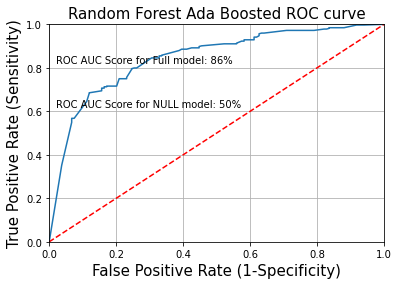

In [39]:
plot_roc_curve(ytest, ypred_prob_rfab, rfab_avgrascore, 'Random Forest Ada Boosted')

In [40]:
round(pd.Series(ypred_rfab).map({0:'Conservative', 1:'Labour'}).value_counts(normalize=True)*100)

Labour          71.0
Conservative    29.0
dtype: float64

The Ada Boost Classifier has reduced the bias error by 3%. The Average ROC AUC score has improved from 83% to 86% keeping the variance error intact as 0.99%. Hence we can say the model is neither overfitting not underfitting. The overall winner is predicted as Labour with 71% of votes. Hence we have built a successfull Machine Learning Classification Model in predicting the overall winner as Labour using Ada Boost Classifer with base model as Random Forest.

# Performance Metrics

Lets find the Accuracy, plot the confusion matrix and display the classification report for all the 4 models.

## Accuracy Score

In [41]:
def get_accuracy(ytrain, ypred_train, ytest, ypred):
    train_acc = accuracy_score(ytrain, ypred_train)
    test_acc = accuracy_score(ytest, ypred)
    return train_acc,test_acc

pred_lst = [[ypred_train, ypred],[ypred_train_rdt, ypred_rdt],
            [ypred_train_rf, ypred_rf],[ypred_train_rfab, ypred_rfab]]  
train_acc_lst = []
test_acc_lst = []

for yptr,yp in pred_lst:
    train_acc,test_acc = get_accuracy(ytrain, yptr, ytest, yp)
    train_acc_lst.append(train_acc)
    test_acc_lst.append(test_acc)
    
scores_df['Training Accuracy'] = train_acc_lst
scores_df['Test Accuracy'] = test_acc_lst
scores_df

,Model Name,Training Score,Test Score,Average Score,Variance Error,Training Accuracy,Test Accuracy
0,Fully Grown Decision Tree,1.000000,0.757762,0.717154,0.019232,1.000000,0.790393
1,Regularized Decision Tree,0.810031,0.807675,0.862819,0.032618,0.842549,0.836245
2,Random Forest,0.974281,0.762668,0.832497,0.009932,0.969072,0.766376
3,Random Forest Ada Boosted,0.992720,0.761102,0.856747,0.020680,0.993440,0.801310


## Classification Report

In [42]:
cr_fgdt = classification_report(ytest, ypred)
print(cr_fgdt)

              precision    recall  f1-score   support

           0       0.63      0.68      0.65       134
           1       0.86      0.84      0.85       324

    accuracy                           0.79       458
   macro avg       0.75      0.76      0.75       458
weighted avg       0.80      0.79      0.79       458



In [43]:
cr_rdt = classification_report(ytest, ypred_rdt)
print(cr_rdt)

              precision    recall  f1-score   support

           0       0.71      0.74      0.73       134
           1       0.89      0.88      0.88       324

    accuracy                           0.84       458
   macro avg       0.80      0.81      0.80       458
weighted avg       0.84      0.84      0.84       458



In [44]:
cr_rf = classification_report(ytest, ypred_rf)
print(cr_rf)

              precision    recall  f1-score   support

           0       0.58      0.75      0.65       134
           1       0.88      0.77      0.82       324

    accuracy                           0.77       458
   macro avg       0.73      0.76      0.74       458
weighted avg       0.79      0.77      0.77       458



In [45]:
cr_rfab = classification_report(ytest, ypred_rfab)
print(cr_rfab)

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       134
           1       0.86      0.86      0.86       324

    accuracy                           0.80       458
   macro avg       0.76      0.76      0.76       458
weighted avg       0.80      0.80      0.80       458



The weighted average F1 score is 80% for Random Forest Ada Boosted, which is a good score. Hence we could say the model built is not underfitting.

## Confusion Matrix

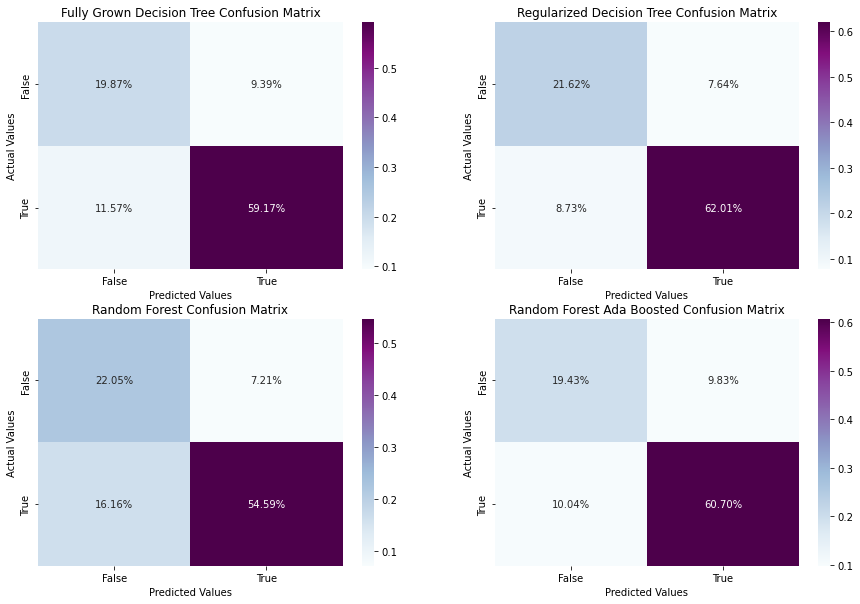

In [46]:
def plot_cf_matrix(ytest, ypred, ax, title):
    cf_matrix = confusion_matrix(ytest, ypred)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='BuPu', ax=ax)

    ax.set_title(title + ' Confusion Matrix')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')

    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    
plt.figure(figsize=(15,10))

for i,yp,title in zip(np.arange(1,5), [ypred, ypred_rdt, ypred_rf, ypred_rfab], model_names):   
    ax = plt.subplot(2, 2, i)
    plot_cf_matrix(ytest, yp, ax, title)
    
plt.show()

The points we note from the above confusion matrix for Random Forest Ada Boosted are 
         * 60.7% of the data is correctly predicted as Labour
         * 19.43% of data is correctly predicted as Conservative
         * 10.04% of data is wrongly predicted as Conservative
         * 9.83% of data is wrongly predicted as Labour.   

In [47]:
cm = confusion_matrix(ytest,ypred_rfab)
s = np.sum(cm,axis=1)
print(cm)
print(cm[0,:]/s[0])
print(cm[1,:]/s[1])

[[ 89  45]
 [ 46 278]]
[0.6641791 0.3358209]
[0.14197531 0.85802469]


Random Forest Ada Boosted Model:

The sensitivity is 85.8%. That is 85.8% of the Labour data is correctly predicted as Labour. 

The specificity is 66.4%. That is 66.4% of the conservative data is correctly predicted as Conservative.

## Inference Comparing all models

In [48]:
scores_df

,Model Name,Training Score,Test Score,Average Score,Variance Error,Training Accuracy,Test Accuracy
0,Fully Grown Decision Tree,1.000000,0.757762,0.717154,0.019232,1.000000,0.790393
1,Regularized Decision Tree,0.810031,0.807675,0.862819,0.032618,0.842549,0.836245
2,Random Forest,0.974281,0.762668,0.832497,0.009932,0.969072,0.766376
3,Random Forest Ada Boosted,0.992720,0.761102,0.856747,0.020680,0.993440,0.801310


The Average score is the crucial score to be considered. Hence according to the average score though Regularized Decision Tree has the highest average score of 86.3%, the variance error is higher for it. 

Hence we have used Random Forest to reduce the variance error to .99% from 3.26%, for which we had to sacrifice on the bias error little bit of around 3%. 

Still to compensate this sacrifice in the bias error, we decided to Boost the Random Forest model using the Ada Boost Classifier, and we successfully achieved almost a similar Average Score of Regularized Decision Tree upto 85.7%. 

Hence we were able to successfully build a Random Forest Ada Boosted Machine Learning model with 85.67% Average ROC AUC Score and a variance error of .99% in predicting the overall win as Labour with 71% of votes.  